In [1]:
import os
import random
import requests
import time
from PIL import Image
import base64
import io
import json
import re
from tqdm import tqdm
import numpy as np

In [2]:
import csv
import random
import time
import json
import copy


import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = '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'
os.environ['LANGSMITH_PROJECT'] = 'pr-wooden-hedgehog-65'
os.environ['OPENAI_API_KEY'] = 'sk-g4MycviIFf8Lad0v5zVKPljDpueIDBLuqIC1nsDAiRnLZVKg'
os.environ['OPENAI_API_BASE'] = 'https://api2.aigcbest.top/v1'

from typing import Any, List, Dict

# LangChain 和 LangSmith 的相关导入
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ChatMessage

def generate_from_openai_chat_completion_new(
    messages: List[Dict[str, str]],
    model: str,
    temperature: float,
    max_tokens: int,
    top_p: float,
    context_length: int, # 这个参数在ChatOpenAI中不直接使用，但为了保持签名一致而保留
    stop_token: str | None = None,
) -> str:
    """
    使用 LangChain 的 ChatOpenAI 生成聊天回复，并支持 LangSmith 追踪。
    函数签名与旧版完全兼容。
    """
    if "OPENAI_API_KEY" not in os.environ and "api_key" not in locals():
        raise ValueError("OPENAI_API_KEY environment variable must be set.")

    # 1. 初始化 LangChain 的 ChatOpenAI 客户端
    # 将旧函数的参数映射到 ChatOpenAI 的构造函数中
    llm = ChatOpenAI(
        # 从环境变量获取 key 和 base_url，提供默认值
        api_key=os.environ.get("OPENAI_API_KEY"),
        base_url=os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1"),
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        stop=[stop_token] if stop_token else None,
        model_kwargs={}, # 如果没有其他高级参数，可以为空字典或直接省略
        # 内置重试机制，替代旧的装饰器
        max_retries=3,
    )

    # 2. 将输入的字典列表转换为 LangChain 的消息对象
    # 这是一个必要的适配步骤
    langchain_messages = []
    for msg in messages:
        role = msg.get("role")
        content = msg.get("content", "")
        # 从字典中获取 name，如果不存在则为 None
        name = msg.get("name")

        if role == "user":
            langchain_messages.append(HumanMessage(content=content, name=name))
        elif role == "assistant":
            langchain_messages.append(AIMessage(content=content, name=name))
        elif role == "system":
            # 这会正确处理您提供的 few-shot 示例
            langchain_messages.append(SystemMessage(content=content, name=name))
        else:
            # 为其他可能的角色（如 'tool'）提供一个通用处理
            langchain_messages.append(ChatMessage(role=role, content=content))

    # 3. 调用 LLM 并获取结果
    response = llm.invoke(langchain_messages)

    # 4. 提取并返回内容，保持与旧函数相同的字符串输出
    return response.content

In [3]:
# example_messages_with_name = [{
#     'role': 'user',
#     'content': "hello"
# }]

# result = generate_from_openai_chat_completion_new(
#     messages=example_messages_with_name,
#     model="gpt-4o",
#     temperature=0.7,
#     max_tokens=2000,
#     top_p=1.0,
#     context_length=4096,
#     stop_token=None
# )

In [4]:
system_prompt = """You are an expert in evaluating GUI agent task trajectories. Your task is to assess the quality and effectiveness of task trajectories for GUI manipulation tasks.

A trajectory consists of the following components:
1. High-level Instruction: Describes the user's overall intended task.
2. Interaction Sequence:
    - For all intermediate steps (Non-final turns):
        - Page Summary: A brief description of the webpage state.
        - Action: The specific operation executed (e.g., click, type).
        - Local Intent: The immediate purpose of that specific action.
    - For the final step (Last turn):
        - Full Accessibility Tree: The complete, simplified representation of the final webpage state.
        - Answer: The agent's final response (often in a Chain-of-Thought format) and the stop command indicating task completion.

When evaluating a trajectory, consider these key aspects:

### Evaluation Criteria:
1. Trajectory Coherence:
   - Do the low-level steps and corresponding actions follow a logical sequence toward the goal?
   - Are the actions clearly described and specific?
   - Are there redundant or unnecessary actions?

2. Task Completion:
   - Does the trajectory successfully achieve the instructed task?
   - Are all necessary interactions completed?
   - Are error cases handled appropriately?

### Scoring Guidelines:
Rate the trajectory on a scale of 1 to 5 based on the evaluation criteria:

- 5: The task is perfectly completed, successfully executing multiple actions to achieve the goal. The sequence is logically clear with no noticeable redundancies.
- 4: The task is mostly completed, successfully executing multiple actions. However, due to challenges or ambiguities in the instructions, the completion is not perfect, or there are inefficiencies in the process.
- 3: The task is partially completed, with some successful actions executed. However, due to task or environmental constraints, the goal is not fully achieved, or the sequence ends in a loop or error.
- 2: Only a few actions are executed. Although there is an attempt to complete the task, the trajectory deviates from the goal early on or demonstrates significant inefficiencies in execution and logic.
- 1: The task fails completely, with no meaningful actions executed at the start. The sequence either falls into an immediate deadlock, a repetitive loop, or demonstrates no value in completing the task.

Note: If the task is relatively complex, but the trajectory demonstrates valuable attempts, even if the task is not fully completed, consider adjusting the score upward. However, if the task is complex but the trajectory fails to perform actions that contribute meaningfully to task completion, no extra points should be awarded.

### Response Format:
Format your response into two lines as shown below: 
Reason: <your thoughts and reasoning process for the score>
Score: <your score from 1-5>"""

In [5]:
import re

def get_a11y_and_action_from_step(step):
    human_message_lines = step['conversations'][0]['value'].split("\n")
    a_11y_lines = []
    a_11y_start_flg = False
    for line in human_message_lines:
        if line.startswith("Accessibility tree:"):
            a_11y_start_flg = True
        elif line.startswith("Action History:"):
            a_11y_start_flg = False

        if a_11y_start_flg:
            a_11y_lines.append(line)

    llm_message = step['conversations'][1]['value']
    try:
        llm_message = re.search(r'```(.*)```', llm_message, re.DOTALL).group(1)
    except Exception as e:
        print(f"error {step['conversations'][1]['value']}")
        llm_message = "WARNING: action is empty"
    return "\n".join(a_11y_lines), llm_message

In [19]:
def format_user_input_string(traj, reverse_intention_traj):
    instruction_line = ""
    split_lines = traj[0]['conversations'][0]['value'].split("\n")
    for line in split_lines:
        if line.startswith("Instruction:"):
            instruction_line = line
            break
    
    if instruction_line == "":
        raise ValueError("Instruction line not found")
    user_prompt = f"Instruction: {instruction_line}\n\n"

    traj_len = len(traj)
    for i in range(traj_len-1):

        page_description = reverse_intention_traj[i]["web_desc_before"]
        intention = reverse_intention_traj[i]["intention"]
        a11y, action = get_a11y_and_action_from_step(traj[i])
        user_prompt += f"""Page{i+1}:
Page Description: {page_description}
Action: {action}
Local Intent: {intention}
        
"""
    a11y, action = get_a11y_and_action_from_step(traj[-1])
    user_prompt += f"""Page{traj_len}:
Final Page Accessibility Tree: {a11y}

Final Answer: {traj[-1]['conversations'][1]['value']}
    """

    user_prompt += f"""
Now, please generate your reason and score.
    """
    return user_prompt


In [20]:
import csv

result_csv_path = "/home/zjusst/qms/osgensis/rating_v2.csv"
if not os.path.exists(result_csv_path):
    with open(result_csv_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["json_file_path", "reason", "score"])


In [25]:
json_dir_path = "/home/zjusst/qms/osgensis/len_5_trajs"

orginal_file_names = os.listdir(json_dir_path)
# 如果已经有对应的 _reverse_intention.json 文件，则跳过原文件
file_names = []
for file_name in orginal_file_names:
    if file_name.endswith("intention.json"):
        print(f"skip {file_name}")
        continue
    file_names.append(file_name)

for json_file_path in tqdm(file_names):
    with open(f"{json_dir_path}/{json_file_path}", "r") as f:
        traj = json.load(f)

    with open(f"{json_dir_path}/{json_file_path[:-5]}_reverse_intention.json", "r") as f:
        reverse_intention_traj = json.load(f)

    user_input_string = format_user_input_string(traj, reverse_intention_traj)
    example_messages_with_name = [{
            'role': 'system',
            'content': system_prompt
        }, 
        {
            'role': 'user',
            'content': user_input_string
        }
    ]

    result = generate_from_openai_chat_completion_new(
        messages=example_messages_with_name,
        model="gpt-4o",
        temperature=0.5,
        max_tokens=1500,
        top_p=0.9,
        context_length=4096,
        stop_token=None
    )

    reason = ""
    score = ""
    result_lines = result.split("\n")
    for line in result_lines:
        if line.startswith("Reason:"):
            reason = line.split(":")[1].strip()
        elif line.startswith("Score:"):
            score = line.split(":")[1].strip()
    
    if not reason or not score:
        raise ValueError("Reason or score not found")

    with open(result_csv_path, "a") as f:
        writer = csv.writer(f)
        writer.writerow([f"{json_dir_path}/{json_file_path}", reason, score])


skip traj_1_reverse_intention.json
skip traj_3_reverse_intention.json
skip traj_8_reverse_intention.json
skip traj_12_reverse_intention.json
skip traj_16_reverse_intention.json
skip traj_20_reverse_intention.json
skip traj_5_reverse_intention.json
skip traj_18_reverse_intention.json
skip traj_21_reverse_intention.json
skip traj_7_reverse_intention.json
skip traj_22_reverse_intention.json
skip traj_0_reverse_intention.json
skip traj_24_reverse_intention.json
skip traj_11_reverse_intention.json
skip traj_6_reverse_intention.json
skip traj_9_reverse_intention.json
skip traj_10_reverse_intention.json
skip traj_23_reverse_intention.json
skip traj_17_reverse_intention.json
skip traj_15_reverse_intention.json
skip traj_2_reverse_intention.json
skip traj_13_reverse_intention.json
skip traj_14_reverse_intention.json
skip traj_19_reverse_intention.json
skip traj_4_reverse_intention.json


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:03<01:34,  3.93s/it]

error 


 48%|████▊     | 12/25 [00:38<00:40,  3.14s/it]

error 


 72%|███████▏  | 18/25 [00:55<00:20,  2.97s/it]

error 


 88%|████████▊ | 22/25 [01:14<00:14,  4.96s/it]

error 


100%|██████████| 25/25 [01:22<00:00,  3.29s/it]


In [30]:
# 读取 /home/zjusst/qms/osgensis/rating.csv
rating_csv_path = "/home/zjusst/qms/osgensis/rating.csv"
with open(rating_csv_path, "r") as f:
    reader = csv.reader(f)
    # 跳过第一行
    next(reader)
    rating_data = [row for row in reader]

traj_len_to_rating_data = {}
for row in rating_data:
    traj_len = row[0].split("/")[-2].split("_")[1]
    if traj_len not in traj_len_to_rating_data:
        traj_len_to_rating_data[traj_len] = []
    traj_len_to_rating_data[traj_len].append(row)

traj_len_to_score_data = {}
for traj_len in ['2', '3', '4', '5']:
    #print(len(traj_len_to_rating_data[traj_len]))
    traj_len_to_score_data[traj_len] = []
    for row in traj_len_to_rating_data[traj_len]:
        traj_len_to_score_data[traj_len].append(row[2])

# traj_len_to_score_data['5']

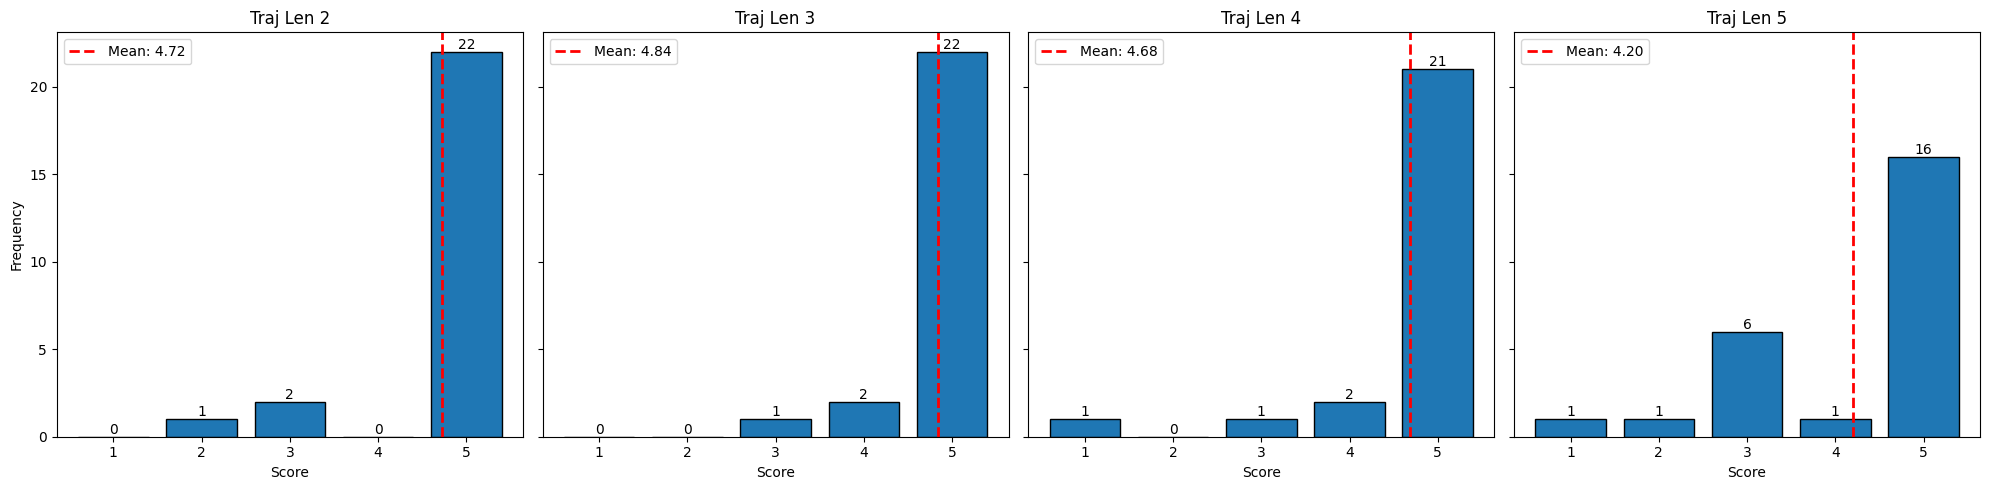

In [31]:
# 绘图，统计每个长度的评分分布
import matplotlib.pyplot as plt

# 统计每个长度的评分分布，柱子上标上数量
# 四个图作为四个子图画在同一个画布上
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
traj_lens = ['2', '3', '4', '5']
for idx, traj_len in enumerate(traj_lens):
    data = traj_len_to_score_data[traj_len]
    counts = {}
    for score in ['1', '2', '3', '4', '5']:
        counts[score] = data.count(score)
    scores = list(counts.keys())
    freq = list(counts.values())

    # 将scores转换为数值，用于x轴定位
    scores_numeric = [int(s) for s in scores]
    bars = axs[idx].bar(scores_numeric, freq, edgecolor='black')
    axs[idx].set_title(f'Traj Len {traj_len}')
    axs[idx].set_xlabel('Score')
    if idx == 0:
        axs[idx].set_ylabel('Frequency')
    # 设置x轴刻度标签为字符串
    axs[idx].set_xticks(scores_numeric)
    axs[idx].set_xticklabels(scores)
    
    # 在柱子上标上数量
    for bar, count in zip(bars, freq):
        axs[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')
    
    # 计算平均值并绘制垂直线
    score_numeric = [int(s) for s in data]
    mean_score = np.mean(score_numeric)
    axs[idx].axvline(x=mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.2f}')
    axs[idx].legend()
    
plt.tight_layout()
plt.show()